# Imports

In [1]:
import ast
import numpy as np
import pandas as pd
import logging
import pennylane as qml
import autograd.numpy as anp
import matplotlib.pyplot as plt

from datetime import date

from tqdm import tqdm

from pennylane import numpy as np_qml

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_blobs, make_circles

from sklearn.model_selection import KFold

seed = 42

np_qml.random.seed(seed)

In [2]:
import warnings

warnings.filterwarnings('ignore', message=".*Graph is not fully connected.*")

In [3]:
# Obter o logger raiz
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Define o nível mínimo de mensagens

# Remover todos os handlers existentes (se houver)
if logger.hasHandlers():
    logger.handlers.clear()

# Criar um FileHandler para salvar as mensagens em um arquivo
file_handler = logging.FileHandler(f'log_{date.today().strftime("%d_%m_%Y")}.log')
file_handler.setLevel(logging.DEBUG)

# Definir o formato das mensagens de log
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
file_handler.setFormatter(formatter)

# Adicionar o FileHandler ao logger
logger.addHandler(file_handler)


# VQC`s

## Circuit

In [4]:
dev = qml.device("lightning.gpu", wires=2)

def statepreparation(x):
    # qml.AmplitudeEmbedding(features=x, wires=range(2), pad_with=0)
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)

def apply_layer(W, layer_number):
    for i in range(len(W) // 2):

        # qml.Rot(W[2 * i, 0], W[2 * i, 1], W[2 * i, 2], wires=0)
        # qml.Rot(W[2 * i + 1, 0], W[2 * i + 1, 1], W[2 * i + 1, 2], wires=1)

        qml.Rot(W[2*i][0], W[2*i][1], W[2*i][2], wires=0)
        qml.Rot(W[2*i+1][0], W[2*i+1][1], W[2*i+1][2], wires=1)
        if i % 2 == 0:
            qml.CNOT(wires=[0, 1])
        else:
            qml.CNOT(wires=[1, 0]) if layer_number > 1 else qml.CNOT(wires=[0, 1])

def circuit(weights, X, layer_number):
    statepreparation(X)

    for W in weights:
        apply_layer(W, layer_number)

    return qml.expval(qml.PauliZ(wires=0))

def qvc_classifier(qnode, w, b, X):
    return qnode(w, X) + b

@qml.qnode(dev, interface="autograd")
def circuit_type1(weights, X):
    return circuit(weights, X, 1)

## Map Prediction

In [5]:
def map_prediction(pred):
    pred = np_qml.array(pred)
    pred = 2 / (1 + np_qml.exp(-pred)) - 1 # Coloca os valores para o intervalo de -1 a 1

    pred = np.array(list(map(lambda x: 1 if x >= 0 else -1, pred))) # Aplica o limitador para mapear os valores para 1 ou -1
    return pred

## Show Decision Region

In [6]:
def print_decision_region(X, qnode, x_max, y_max, weights, bias, predictions):
    plt.figure()
    cm = 'viridis'

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

    features_grid = np.array(
        [x for x in X_grid]
    )  # angles for state preparation are new features
    predictions_grid = [qvc_classifier(qnode, weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # plot decision regions
    cnt = plt.contourf(
        xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both"
    )
    plt.contour(
        xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,)
    )
    plt.colorbar(cnt, ticks=[-1, 1])

    # if predictions are provided, plot data points colored by predictions
    predictions = np.array(predictions)
    
    # Pinta os pontos baseados nas previsões
    plt.scatter(
        X[:, 0], 
        X[:, 1], 
        c=predictions,  # Usa as previsões para determinar as cores
        cmap='viridis',  # Mapa de cores para representar os valores contínuos de previsões
        marker="o",
        edgecolors="k"
    )

    plt.show()


In [7]:
def print_decision_region(X, qnode, x_max, y_max, weights, bias, predictions):
    plt.figure()
    cm = 'viridis'

    # Make data for decision regions
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = np.array([np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())])
    
    # Generate predictions for grid
    predictions_grid = [qvc_classifier(qnode, weights, bias, xi) for xi in X_grid]
    Z = np.reshape(predictions_grid, xx.shape)

    # Plot decision regions
    cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), 
                      cmap=cm, alpha=0.8, extend="both")
    plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), 
               linestyles=("--",), linewidths=(0.8,))
    plt.colorbar(cnt, ticks=[-1, 1])

    # Plot data points with predictions
    predictions = np.array(predictions)
    plt.scatter(X[:, 0], X[:, 1], c=predictions, cmap=cm, 
               marker="o", edgecolors="k")

    # Calculate and display metrics
    if len(np.unique(predictions)) > 1:
        silhouette = silhouette_score(X, predictions)
        davies = davies_bouldin_score(X, predictions)
        calinski = calinski_harabasz_score(X, predictions)
        
        metric_text = (
            f"Silhouette: {silhouette:.2f}\n"
            f"Davies-Bouldin: {davies:.2f}\n"
            f"Calinski-Harabasz: {calinski:.2f}"
        )
        
        plt.text(0.95, 0.95, metric_text,
                 transform=plt.gca().transAxes,
                 ha='right', va='top',
                 bbox=dict(facecolor='white', alpha=0.8, 
                          edgecolor='gray', boxstyle='round'))
    else:
        plt.text(0.95, 0.95, "Metrics require\nmultiple clusters",
                 transform=plt.gca().transAxes,
                 ha='right', va='top',
                 bbox=dict(facecolor='white', alpha=0.8,
                          edgecolor='gray', boxstyle='round'))

    plt.title("Decision Region with Clustering Metrics")
    plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessário para projeção 3D

def print_decision_region_3d(X, qnode, x_max, y_max, weights, bias, predictions):
    """
    Plota a região de decisão em 3D, onde o eixo z representa os valores das predições.
    
    Parâmetros:
      - X: dados de entrada (array com duas colunas para os eixos x e y)
      - qnode: função ou objeto que representa o nó quântico
      - x_max: valor máximo para o eixo x
      - y_max: valor máximo para o eixo y
      - weights: pesos do classificador
      - bias: bias do classificador
      - predictions: predições associadas aos pontos de X
    """
    
    # Criação da figura 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cm = 'viridis'
    
    # Gerar a grade para as regiões de decisão
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 20), np.linspace(0.0, y_max, 20))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
    
    # Preparar os features da grade e calcular as predições para cada ponto
    features_grid = np.array(X_grid)
    predictions_grid = [qvc_classifier(qnode, weights, bias, xi) for xi in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)
    
    # Plotar a superfície da região de decisão
    surf = ax.plot_surface(xx, yy, Z, cmap=cm, alpha=0.8, edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Predição')
    
    # Plotar as linhas de contorno no plano xy, projetando os contornos da superfície
    cset = ax.contour(xx, yy, Z, zdir='z', offset=np.min(Z)-0.1, cmap=cm, levels=np.arange(-1, 1.1, 0.1))
    
    # Plotar os pontos de dados originais, com o eixo z definido pelas predições
    predictions = np.array(predictions)
    scatter = ax.scatter(X[:, 0], X[:, 1], predictions, c=predictions, cmap=cm,
                         marker="o", edgecolors="k", s=50)
    
    # Configurar os limites dos eixos
    ax.set_xlim(0.0, x_max)
    ax.set_ylim(0.0, y_max)
    ax.set_zlim(np.min(Z)-0.1, np.max(Z)+0.1)
    
    # Rótulos dos eixos
    ax.set_xlabel('Eixo X')
    ax.set_ylabel('Eixo Y')
    ax.set_zlabel('Predição')
    
    plt.show()


## Cost Function

In [8]:
def normalize_metric(metric_value, min_val, max_val, invert=False):
    if max_val == min_val:
        return 0.0  # Evita divisão por zero
    normalized = (metric_value - min_val) / (max_val - min_val)
    return (1 - normalized) if invert else normalized

In [9]:
weights = {
    "davies_bouldin": 0.5,
    "silhouette": 0.25,
    "calinski_harabasz": 0.25,
}

In [10]:
def composite_cost_function(X, predictions, metric_ranges):
    if len(np.unique(predictions)) <= 1:
        return 1.0  # Penaliza clusters únicos
    
    # Calcula métricas
    silhouette = silhouette_score(X, predictions)
    davies = davies_bouldin_score(X, predictions)
    calinski = calinski_harabasz_score(X, predictions)
    
    # Normaliza métricas
    silhouette_norm = normalize_metric(
        silhouette, 
        metric_ranges["silhouette_min"], 
        metric_ranges["silhouette_max"]
    )
    davies_norm = normalize_metric(
        davies,
        metric_ranges["davies_min"], 
        metric_ranges["davies_max"],
        invert=True  # Quanto menor o DBI, melhor
    )
    calinski_norm = normalize_metric(
        calinski,
        metric_ranges["calinski_min"], 
        metric_ranges["calinski_max"]
    )
    
    # Combinação ponderada
    composite_score = (
        weights["silhouette"] * silhouette_norm +
        weights["davies_bouldin"] * davies_norm +
        weights["calinski_harabasz"] * calinski_norm
    )
    
    # Converte para custo (menor é melhor)
    return 1 - composite_score

In [12]:
metric_ranges = {
    "silhouette_min": -1,
    "silhouette_max": 1,
    "davies_min": 0,
    "davies_max": 5,
    "calinski_min": 0,
    "calinski_max": 5500,
}

In [ ]:
def cost(
        weights,
        bias, 
        qnode,
        features
    ):
    predictions = np_qml.array(
        [
            qvc_classifier(
                qnode,
                weights, 
                bias, 
                xi
            ) for xi in features
        ]
    )

    logger.info(f"shape of predictions: {np.array(predictions).shape}")
    if(len(predictions) == 1): 
        predictions = np.array(predictions).reshape(len(predictions[0]), 1)

    predictions = map_prediction(predictions)    

    if len(np.unique(predictions)) == 1: # Penaliza o circuito se tiver prevendo somente um cluster
        metric = np_qml.float16(1)
    else: 
        metric = 1 - silhouette_score(features, predictions)
        # metric = composite_cost_function(features, predictions, metric_ranges)

    # l2 = 0.01 * (np_qml.sum(bias**2) + np_qml.sum(weights**2))
    
    return metric

## Train Function

In [14]:
# Função para calcular uma pontuação composta
# def calculate_composite_score(cost, silhouette, davies_bouldin, calinski_harabasz):
#     # Normalize as métricas (ajuste os pesos conforme necessário)
#     normalized_cost = 1 / (1 + cost)  # Quanto menor o custo, melhor
#     normalized_silhouette = silhouette  # Quanto maior, melhor
#     normalized_davies_bouldin = 1 / (1 + davies_bouldin)  # Quanto menor, melhor
#     normalized_calinski_harabasz = calinski_harabasz  # Quanto maior, melhor

#     # Combine as métricas (ajuste os pesos conforme necessário)
#     composite_score = (
#         0.3 * normalized_cost +
#         0.2 * normalized_silhouette +
#         0.2 * normalized_davies_bouldin +
#         0.1 * normalized_calinski_harabasz
#     )
#     return composite_score


def calculate_composite_score(
    cost, 
    silhouette, 
    davies_bouldin, 
    calinski_harabasz,
    min_cost, max_cost,
    min_silhouette, max_silhouette,
    min_davies, max_davies,
    min_calinski, max_calinski
):
    # Normalização min-max com tratamento para divisão por zero
    def normalize(value, min_val, max_val, reverse=False):
        if max_val == min_val:
            return 0.5  # Valor neutro se todos forem iguais
        if reverse:
            return (max_val - value) / (max_val - min_val)  # Quanto menor, melhor
        else:
            return (value - min_val) / (max_val - min_val)  # Quanto maior, melhor

    # Aplicar normalização
    norm_cost = normalize(cost, min_cost, max_cost, reverse=True)
    norm_silhouette = normalize(silhouette, min_silhouette, max_silhouette) if silhouette is not None else 0
    norm_davies = normalize(davies_bouldin, min_davies, max_davies, reverse=True) if davies_bouldin is not None else 0
    norm_calinski = normalize(calinski_harabasz, min_calinski, max_calinski) if calinski_harabasz is not None else 0

    # Calcular pontuação composta (ajuste os pesos)
    composite_score = (
        0.3 * norm_cost +
        0.3 * norm_silhouette +
        0.2 * norm_davies +
        0.2 * norm_calinski
    )
    return composite_score

### K-Fold

In [15]:
def train_kfold(
    qnode, 
    features, 
    num_params_w_lines, 
    num_params_w_columns, 
    num_layers, 
    weight_init_max, 
    optimizer, 
    dic_optimizer, 
    seed, 
    iterations=100, 
    k=10,
    batch_size=32,
    show_log=False
):
    # Initialize k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    folders_metrics = []
    
    # Loop over folds
    for fold_idx, (train_index, val_index) in enumerate(kf.split(features)):
        X_train, X_val = features[train_index], features[val_index]

        all_costs = []  # To store cost values
        all_iterations = []

        # Initialize optimizer
        opt = optimizer(**dic_optimizer)
        
        # Initialize weights and bias
        # weights_init = weight_init_max * np.random.randn(num_layers, num_params_w_lines, num_params_w_columns)

        ## TESTE
        ### Utilizar uma distribuicao uniforme para inicializar os pesos
        weights_init = np_qml.random.uniform(-weight_init_max, weight_init_max, (num_layers, num_params_w_lines, num_params_w_columns), requires_grad=True)
        # Convert to a PyTorch tensor with requires_grad=True

        bias_init = np_qml.array(0.0, requires_grad=True)

        weights = weights_init
        bias = bias_init

        folder_infos = {
            "folder": fold_idx + 1,
            "best_weights": weights,
            "best_bias": bias,
            "best_cost": float('inf'),
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None
        }

        patience = 20
        no_improvement = 0

        # Training loop
        for it in range(iterations):
            # Mini-batch sampling

            # Mini-batch sampling (garanta que não exceda o tamanho do dataset)
            if batch_size > len(X_train):
                batch_size = len(X_train)

            batch_index = np.random.choice(len(X_train), batch_size, replace=False)
            X_train_batch = X_train[batch_index]

            # Train model on batch
            arguments = [weights, bias]
            (weights, bias), iteration_cost = opt.step_and_cost(lambda w, b: cost(w, b, qnode, X_train_batch), *arguments)

            # Update best weights and bias
            if iteration_cost < folder_infos['best_cost']:
                folder_infos['best_weights'] = weights
                folder_infos['best_bias'] = bias
                folder_infos['best_cost'] = iteration_cost

                no_improvement = 0
            else:
                no_improvement += 1
    
            all_costs.append(iteration_cost)
            all_iterations.append(it + 1)        

            logger.info(f"Fold: {fold_idx + 1} | Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {folder_infos['best_cost']:0.7f}")

            if no_improvement >= patience:
                break

        # Validation metrics
        predictions_val = [qvc_classifier(qnode, folder_infos['best_weights'], folder_infos['best_bias'], xi) for xi in X_val]
        predictions_val = map_prediction(predictions_val)
        
        if len(np.unique(predictions_val)) > 1:
            folder_infos['davies_bouldin'] = davies_bouldin_score(X_val, predictions_val)
            folder_infos['calinski_harabasz'] = calinski_harabasz_score(X_val, predictions_val)
            folder_infos['silhouette'] = silhouette_score(X_val, predictions_val)

        folders_metrics.append(folder_infos)

        # Plot cost evolution
        # if show_log:
        #     plt.plot(all_iterations, all_costs, label="Custo")
        #     plt.title(f"Evolução da Função de Custo (Fold {fold_idx + 1})")
        #     plt.xlabel("Iteração")
        #     plt.ylabel("Custo")
        #     plt.legend()
        #     plt.show()

        if show_log:
            # Definir o grau do polinômio (ex: 2 para quadrático, 3 para cúbico)
            grau_polinomio = 4  # Tente aumentar para 3 ou 4 se necessário

            # Ajuste polinomial
            coef = np.polyfit(all_iterations, all_costs, grau_polinomio)
            poly_eq = np.poly1d(coef)  # Criar a equação polinomial

            # Gerar valores da curva ajustada
            iter_range = np.linspace(min(all_iterations), max(all_iterations), 100)  # Mais pontos para suavizar a curva
            trend_line = poly_eq(iter_range)

            # Plotar os dados originais
            plt.plot(all_iterations, all_costs, label="Custo", marker="o", linestyle="-")

            # Plotar a curva polinomial ajustada
            plt.plot(iter_range, trend_line, label=f"Aproximação Polinomial (grau {grau_polinomio})", linestyle="--", color="red")

            # Configurações do gráfico
            plt.title(f"Evolução da Função de Custo (Fold {fold_idx + 1})")
            plt.xlabel("Iteração")
            plt.ylabel("Custo")
            plt.legend()
            plt.show()

    # Aplicar min-max scaling para normalizar as métricas
    all_costs = [f["best_cost"] for f in folders_metrics]
    all_silhouettes = [f["silhouette"] for f in folders_metrics if f["silhouette"] is not None]
    all_davies = [f["davies_bouldin"] for f in folders_metrics if f["davies_bouldin"] is not None]
    all_calinski = [f["calinski_harabasz"] for f in folders_metrics if f["calinski_harabasz"] is not None]
    
    print(folders_metrics)
    print(all_costs)

    min_cost, max_cost = min(all_costs), max(all_costs)
    min_sil, max_sil = min(all_silhouettes or [0]), max(all_silhouettes or [0])
    min_davies, max_davies = min(all_davies or [0]), max(all_davies or [0])
    min_cal, max_cal = min(all_calinski or [0]), max(all_calinski or [0])

    # Calcula a pontuação composta para cada fold
    for folder in folders_metrics:
        folder["composite_score"] = calculate_composite_score(
            folder["best_cost"],
            folder["silhouette"],
            folder["davies_bouldin"],
            folder["calinski_harabasz"],
            min_cost, max_cost,
            min_sil, max_sil,
            min_davies, max_davies,
            min_cal, max_cal
        )

    # Seleciona o melhor fold com base na pontuação composta
    best_folder = max(folders_metrics, key=lambda d: d["composite_score"])

    logger.info(f'A melhor Fold foi a {best_folder["folder"]}')
    logger.info(f'Custo: {best_folder["best_cost"]}')
    logger.info(f'Silhouette: {best_folder["silhouette"]}')
    logger.info(f'Davies Bouldin: {best_folder["davies_bouldin"]}')
    logger.info(f'Calinski Harabasz: {best_folder["calinski_harabasz"]}')
    logger.info(f'Pontuação Composta: {best_folder["composite_score"]}')

    # Plot decision region for best fold
    predictions = [qvc_classifier(qnode, best_folder['best_weights'], best_folder['best_bias'], xi) for xi in features]
    predictions = map_prediction(predictions)
    print_decision_region_3d(features, qnode, x_max=np.pi, y_max=np.pi, weights=best_folder['best_weights'], bias=best_folder['best_bias'], predictions=predictions)

    return best_folder["best_cost"], best_folder["best_weights"], best_folder["best_bias"], best_folder["silhouette"], best_folder["davies_bouldin"], best_folder["calinski_harabasz"]

### 70/30

In [15]:
def train_70_30(
    qnode, 
    features, 
    num_params_w_lines, 
    num_params_w_columns, 
    num_layers, 
    weight_init_max, 
    optimizer, 
    dic_optimizer, 
    seed, 
    iterations=100, 
    batch_size=32,
    show_log=False
):
    # Split data into 70% training and 30% validation
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)
    
    all_costs = []  # To store cost values
    all_iterations = []

    # Initialize optimizer
    opt = optimizer(**dic_optimizer)
    
    # Initialize weights and bias with uniform distribution
    weights_init = np_qml.random.uniform(
        -weight_init_max, weight_init_max, 
        (num_layers, num_params_w_lines, num_params_w_columns), 
        requires_grad=True
    )
    bias_init = np_qml.array(0.0, requires_grad=True)

    weights = weights_init
    bias = bias_init

    training_info = {
        "best_weights": weights,
        "best_bias": bias,
        "best_cost": float('inf'),
        "silhouette": None,
        "davies_bouldin": None,
        "calinski_harabasz": None
    }

    patience = 20
    no_improvement = 0

    # Training loop
    for it in range(iterations):
        # Mini-batch sampling (ensure batch_size doesn't exceed training data size)
        current_batch_size = min(batch_size, len(X_train))
        batch_index = np.random.choice(len(X_train), current_batch_size, replace=False)
        X_train_batch = X_train[batch_index]

        # Train model on batch
        arguments = [weights, bias]
        (weights, bias), iteration_cost = opt.step_and_cost(
            lambda w, b: cost(w, b, qnode, X_train_batch), *arguments
        )

        # Update best weights and bias if cost improves
        if iteration_cost < training_info['best_cost']:
            training_info['best_weights'] = weights
            training_info['best_bias'] = bias
            training_info['best_cost'] = iteration_cost
            no_improvement = 0
        else:
            no_improvement += 1

        all_costs.append(iteration_cost)
        all_iterations.append(it + 1)        

        logger.info(f"Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {training_info['best_cost']:0.7f}")

        # Early stopping if no improvement
        if no_improvement >= patience:
            break


    if show_log:
        # Definir o grau do polinômio (ex: 2 para quadrático, 3 para cúbico)
        grau_polinomio = 4  # Tente aumentar para 3 ou 4 se necessário

        # Ajuste polinomial
        coef = np.polyfit(all_iterations, all_costs, grau_polinomio)
        poly_eq = np.poly1d(coef)  # Criar a equação polinomial

        # Gerar valores da curva ajustada
        iter_range = np.linspace(min(all_iterations), max(all_iterations), 100)  # Mais pontos para suavizar a curva
        trend_line = poly_eq(iter_range)

        # Plotar os dados originais
        plt.plot(all_iterations, all_costs, label="Custo", marker="o", linestyle="-")

        # Plotar a curva polinomial ajustada
        plt.plot(iter_range, trend_line, label=f"Aproximação Polinomial (grau {grau_polinomio})", linestyle="--", color="red")

        # Configurações do gráfico
        plt.title(f"Evolução da Função de Custo")
        plt.xlabel("Iteração")
        plt.ylabel("Custo")
        plt.legend()
        plt.show()

    # Validation metrics
    predictions_val = [qvc_classifier(qnode, training_info['best_weights'], training_info['best_bias'], xi) for xi in X_val]
    predictions_val = map_prediction(predictions_val)
    
    if len(np.unique(predictions_val)) > 1:
        training_info['davies_bouldin'] = davies_bouldin_score(X_val, predictions_val)
        training_info['calinski_harabasz'] = calinski_harabasz_score(X_val, predictions_val)
        training_info['silhouette'] = silhouette_score(X_val, predictions_val)

    # Plot cost evolution if enabled
    if show_log:
        plt.plot(all_iterations, all_costs, label="Custo", marker="o", linestyle="-")
        plt.title("Evolução da Função de Custo")
        plt.xlabel("Iteração")
        plt.ylabel("Custo")
        plt.legend()
        plt.show()

    # Plot decision region
    predictions = [qvc_classifier(qnode, training_info['best_weights'], training_info['best_bias'], xi) for xi in features]
    predictions = map_prediction(predictions)
    print_decision_region(features, qnode, x_max=np.pi, y_max=np.pi, 
                           weights=training_info['best_weights'], bias=training_info['best_bias'], 
                           predictions=predictions)

    logger.info(f'Custo Final: {training_info["best_cost"]}')
    logger.info(f'Silhouette: {training_info["silhouette"]}')
    logger.info(f'Davies Bouldin: {training_info["davies_bouldin"]}')
    logger.info(f'Calinski Harabasz: {training_info["calinski_harabasz"]}')

    return (training_info["best_cost"], 
            training_info["best_weights"], 
            training_info["best_bias"], 
            training_info["silhouette"], 
            training_info["davies_bouldin"], 
            training_info["calinski_harabasz"])

### GA

In [22]:
def genetic_algorithm_train(
    qnode,
    features,
    num_params_w_lines,
    num_params_w_columns,
    num_layers,
    weight_init_max,
    seed,
    iterations=100,
    population_size=50,
    mutation_rate=0.1,
    crossover_rate=0.8,
    show_log=False
):
    # Split dos dados
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)
    
    # Hiperparâmetros
    num_weights = num_layers * num_params_w_lines * num_params_w_columns
    total_params = num_weights + 1  # +1 para o bias
    
    # Inicialização da população
    population = np.random.uniform(
        -weight_init_max, 
        weight_init_max, 
        (population_size, total_params)
    )
    population[:, -1] = 0.0  # Inicializa bias com 0
    
    best_solution = None
    best_fitness = float('inf')
    fitness_history = []
    
    for generation in range(iterations):
        # Avaliação de fitness
        fitness = []
        for individual in population:
            weights = individual[:-1].reshape(
                (num_layers, num_params_w_lines, num_params_w_columns)
            )
            bias = individual[-1]
            fitness_val = cost(weights, bias, qnode, X_train)
            fitness.append(fitness_val)
        
        # Seleção por torneio
        selected_indices = []
        for _ in range(population_size):
            candidates = np.random.choice(population_size, size=3, replace=False)
            winner = candidates[np.argmin([fitness[i] for i in candidates])]
            selected_indices.append(winner)
        
        # Crossover e mutação
        new_population = []
        for i in range(0, population_size, 2):
            parent1 = population[selected_indices[i]]
            parent2 = population[selected_indices[i+1]]
            
            # Crossover uniforme
            mask = np.random.rand(total_params) < crossover_rate
            child1 = np.where(mask, parent1, parent2)
            child2 = np.where(mask, parent2, parent1)
            
            # Mutação gaussiana
            mutation_mask = np.random.rand(total_params) < mutation_rate
            child1 += mutation_mask * np.random.normal(0, 0.1, total_params)
            child2 += mutation_mask * np.random.normal(0, 0.1, total_params)
            
            new_population.extend([child1, child2])
        
        population = np.array(new_population)
        
        # Atualiza melhor solução
        current_best = np.min(fitness)
        if current_best < best_fitness:
            best_idx = np.argmin(fitness)
            best_solution = population[best_idx]
            best_fitness = current_best
        
        fitness_history.append(best_fitness)
        logger.info(f"Gen {generation+1}: Best Fitness = {best_fitness:.4f}")

    # Recupera pesos e bias
    best_weights = best_solution[:-1].reshape(
        (num_layers, num_params_w_lines, num_params_w_columns)
    )
    best_bias = best_solution[-1]
    
    # Métricas de validação
    predictions_val = [qvc_classifier(qnode, best_weights, best_bias, xi) for xi in X_val]
    predictions_val = map_prediction(predictions_val)
    
    metrics = {
        "silhouette": silhouette_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "davies_bouldin": davies_bouldin_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "calinski_harabasz": calinski_harabasz_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None
    }
    
    return (best_fitness, best_weights, best_bias, 
            metrics["silhouette"], metrics["davies_bouldin"], metrics["calinski_harabasz"])

### PSO

In [26]:
class Particle:
    def __init__(self, position):
        self.position = position
        self.velocity = np.zeros_like(position)
        self.best_position = position.copy()
        self.best_fitness = float('inf')

def pso_train(
    qnode,
    features,
    num_params_w_lines,
    num_params_w_columns,
    num_layers,
    weight_init_max,
    seed,
    iterations=100,
    num_particles=30,
    inertia=0.7,
    cognitive_coeff=1.5,
    social_coeff=1.5,
    show_log=False
):
    # Split dos dados
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)
    
    # Cálculo de parâmetros
    num_weights = num_layers * num_params_w_lines * num_params_w_columns
    total_params = num_weights + 1  # +1 para o bias
    
    # Inicialização das partículas
    np.random.seed(seed)
    particles = []
    global_best_position = None
    global_best_fitness = float('inf')
    fitness_history = []

    for _ in range(num_particles):
        position = np.random.uniform(-weight_init_max, weight_init_max, total_params)
        position[-1] = 0.0  # Inicialização do bias
        particles.append(Particle(position))

    # Loop de treinamento
    for epoch in range(iterations):
        for particle in particles:
            # Extrai pesos e bias
            weights = particle.position[:-1].reshape(
                (num_layers, num_params_w_lines, num_params_w_columns)
            )
            bias = particle.position[-1]
            
            # Calcula fitness
            current_fitness = cost(weights, bias, qnode, X_train)
            
            # Atualiza melhores locais/globais
            if current_fitness < particle.best_fitness:
                particle.best_fitness = current_fitness
                particle.best_position = particle.position.copy()
                
            if current_fitness < global_best_fitness:
                global_best_fitness = current_fitness
                global_best_position = particle.position.copy()

        # Atualiza velocidades e posições
        for particle in particles:
            r1, r2 = np.random.rand(2)
            particle.velocity = (
                inertia * particle.velocity +
                cognitive_coeff * r1 * (particle.best_position - particle.position) +
                social_coeff * r2 * (global_best_position - particle.position)
            )
            particle.position += particle.velocity
        
        fitness_history.append(global_best_fitness)
        logger.info(f"Epoch {epoch+1}: Best Fitness = {global_best_fitness:.4f}")

    # Processa a melhor solução
    best_weights = global_best_position[:-1].reshape(
        (num_layers, num_params_w_lines, num_params_w_columns)
    )
    best_bias = global_best_position[-1]

    # Métricas de validação
    predictions_val = [qvc_classifier(qnode, best_weights, best_bias, xi) for xi in X_val]
    predictions_val = map_prediction(predictions_val)
    
    metrics = {
        "silhouette": silhouette_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "davies_bouldin": davies_bouldin_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "calinski_harabasz": calinski_harabasz_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None
    }

    return (
        global_best_fitness,
        best_weights,
        best_bias,
        metrics["silhouette"],
        metrics["davies_bouldin"],
        metrics["calinski_harabasz"]
    )

### Simulated Anneiling

In [33]:
import math

def simulated_annealing_train(
    qnode,
    features,
    num_params_w_lines,
    num_params_w_columns,
    num_layers,
    weight_init_max,
    seed,
    iterations=1000,
    initial_temp=1000.0,
    cooling_rate=0.95,
    show_log=False
):
    # Split dos dados
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)
    
    # Configuração inicial
    np.random.seed(seed)
    num_weights = num_layers * num_params_w_lines * num_params_w_columns
    total_params = num_weights + 1  # +1 para o bias
    
    # Inicialização da solução
    current_solution = np.random.uniform(
        -weight_init_max, 
        weight_init_max, 
        total_params
    )
    current_solution[-1] = 0.0  # Inicializa bias com 0
    
    # Decodifica parâmetros iniciais
    current_weights = current_solution[:-1].reshape(
        (num_layers, num_params_w_lines, num_params_w_columns)
    )
    current_bias = current_solution[-1]
    
    # Calcula custo inicial
    current_cost = cost(current_weights, current_bias, qnode, X_train)
    best_solution = current_solution.copy()
    best_cost = current_cost
    cost_history = [current_cost]

    # Configuração do resfriamento
    temp = initial_temp

    for i in range(iterations):
        # Gera solução vizinha
        neighbor = current_solution + np.random.normal(0, temp/initial_temp, total_params)
        
        # Decodifica nova solução
        neighbor_weights = neighbor[:-1].reshape(
            (num_layers, num_params_w_lines, num_params_w_columns)
        )
        neighbor_bias = neighbor[-1]
        
        # Calcula custo da nova solução
        neighbor_cost = cost(neighbor_weights, neighbor_bias, qnode, X_train)

        # Decisão de aceitação
        if neighbor_cost < current_cost:
            # Aceita soluções melhores
            current_solution = neighbor
            current_cost = neighbor_cost
        else:
            # Aceita soluções piores com probabilidade de Boltzmann
            prob = math.exp(-(neighbor_cost - current_cost) / temp)
            if np.random.rand() < prob:
                current_solution = neighbor
                current_cost = neighbor_cost

        # Atualiza melhor solução global
        if current_cost < best_cost:
            best_solution = current_solution.copy()
            best_cost = current_cost

        # Resfriamento
        temp *= cooling_rate
        cost_history.append(best_cost)

        # Log de progresso
        if show_log and (i % 100 == 0):
            logger.info(f"Iter {i+1}: Temp = {temp:.2f} | Current Cost = {current_cost:.4f} | Best Cost = {best_cost:.4f}")

    # Processa melhor solução encontrada
    best_weights = best_solution[:-1].reshape(
        (num_layers, num_params_w_lines, num_params_w_columns)
    )
    best_bias = best_solution[-1]

    # Métricas de validação
    predictions_val = [qvc_classifier(qnode, best_weights, best_bias, xi) for xi in X_val]
    predictions_val = map_prediction(predictions_val)
    
    metrics = {
        "silhouette": silhouette_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "davies_bouldin": davies_bouldin_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "calinski_harabasz": calinski_harabasz_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None
    }

    # Plotagem do custo (se habilitado)
    if show_log:
        plt.plot(cost_history, label="Melhor Custo")
        plt.title("Evolução do Custo - Simulated Annealing")
        plt.xlabel("Iteração")
        plt.ylabel("Custo")
        plt.legend()
        plt.show()

    return (
        best_cost,
        best_weights,
        best_bias,
        metrics["silhouette"],
        metrics["davies_bouldin"],
        metrics["calinski_harabasz"]
    )

### Bay

In [36]:
from skopt import gp_minimize
from skopt.space import Real

def bayesian_optimization_train(
    qnode,
    features,
    num_params_w_lines,
    num_params_w_columns,
    num_layers,
    weight_init_max,
    seed,
    n_calls=50,
    n_initial_points=10,
    show_log=False
):
    # Split dos dados
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)
    
    # Configuração do espaço de busca
    num_weights = num_layers * num_params_w_lines * num_params_w_columns
    total_params = num_weights + 1  # +1 para o bias
    
    # Define o espaço de busca para cada parâmetro
    space = [Real(-weight_init_max, weight_init_max, name=f'w_{i}') for i in range(num_weights)]
    space += [Real(-weight_init_max, weight_init_max, name='bias')]

    # Histórico de custos
    cost_history = []

    # Função objetivo para o Bayesian Optimization
    def objective(params):
        try:
            # Converte para array numpy e separa pesos/bias
            params = np.array(params)
            weights = params[:-1].reshape(
                (num_layers, num_params_w_lines, num_params_w_columns)
            )
            bias = params[-1]
            
            # Calcula o custo
            current_cost = cost(weights, bias, qnode, X_train)
            cost_history.append(current_cost)
            
            return current_cost
        except Exception as e:
            logger.error(f"Error in objective function: {e}")
            return float('inf')

    # Executa a otimização
    result = gp_minimize(
        func=objective,
        dimensions=space,
        n_calls=n_calls,
        n_initial_points=n_initial_points,
        random_state=seed,
        verbose=show_log
    )

    # Recupera a melhor solução
    best_params = result.x
    best_weights = np.array(best_params[:-1]).reshape(
        (num_layers, num_params_w_lines, num_params_w_columns)
    )
    best_bias = best_params[-1]
    best_cost = result.fun

    # Métricas de validação
    predictions_val = [qvc_classifier(qnode, best_weights, best_bias, xi) for xi in X_val]
    predictions_val = map_prediction(predictions_val)
    
    metrics = {
        "silhouette": silhouette_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "davies_bouldin": davies_bouldin_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "calinski_harabasz": calinski_harabasz_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None
    }

    # Plotagem da convergência
    if show_log:
        plt.figure(figsize=(10, 6))
        plt.plot(cost_history, 'bo-', label='Custo por Avaliação')
        plt.plot(np.minimum.accumulate(cost_history), 'r--', label='Melhor Custo')
        plt.title("Convergência da Otimização Bayesiana")
        plt.xlabel("Número de Avaliações")
        plt.ylabel("Custo")
        plt.legend()
        plt.show()

    return (
        best_cost,
        best_weights,
        best_bias,
        metrics["silhouette"],
        metrics["davies_bouldin"],
        metrics["calinski_harabasz"]
    )

### DE

In [42]:
def differential_evolution_train(
    qnode,
    features,
    num_params_w_lines,
    num_params_w_columns,
    num_layers,
    weight_init_max,
    seed,
    iterations=100,
    pop_size=50,
    F=0.8,
    CR=0.9,
    show_log=False
):
    # Split dos dados
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)
    
    # Configuração dos parâmetros
    num_weights = num_layers * num_params_w_lines * num_params_w_columns
    total_params = num_weights + 1  # +1 para o bias
    
    # Inicialização da população
    np.random.seed(seed)
    population = np.random.uniform(
        -weight_init_max,
        weight_init_max,
        (pop_size, total_params)
    )  # Parêntese faltando corrigido
    population[:, -1] = 0.0  # Inicializa bias com 0
    
    best_solution = None
    best_fitness = float('inf')
    fitness_history = []

    # Função para avaliar indivíduos
    def evaluate(individual):
        weights = individual[:-1].reshape(
            (num_layers, num_params_w_lines, num_params_w_columns)
        )  # Parêntese faltando corrigido
        bias = individual[-1]
        return cost(weights, bias, qnode, X_train)

    # Avaliação inicial
    fitness = np.array([evaluate(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]
    fitness_history.append(best_fitness)

    # Loop de evolução
    for gen in range(iterations):
        for i in range(pop_size):
            # Seleciona 3 índices diferentes
            idxs = [j for j in range(pop_size) if j != i]
            candidates = np.random.choice(idxs, 3, replace=False)
            a, b, c = population[candidates]
            
            # Cria vetor doador
            donor = a + F * (b - c)
            
            # Crossover binomial
            cross_points = np.random.rand(total_params) < CR
            trial = np.where(cross_points, donor, population[i])
            
            # Seleção
            trial_fitness = evaluate(trial)
            if trial_fitness < fitness[i]:
                population[i] = trial
                fitness[i] = trial_fitness
                
                if trial_fitness < best_fitness:
                    best_solution = trial.copy()
                    best_fitness = trial_fitness
        
        fitness_history.append(best_fitness)
        logger.info(f"Generation {gen+1}: Best Fitness = {best_fitness:.4f}")

    # Processa melhor solução
    best_weights = best_solution[:-1].reshape(
        (num_layers, num_params_w_lines, num_params_w_columns)
    )  # Parêntese faltando corrigido
    best_bias = best_solution[-1]

    # Métricas de validação
    predictions_val = [qvc_classifier(qnode, best_weights, best_bias, xi) for xi in X_val]
    predictions_val = map_prediction(predictions_val)
    
    metrics = {
        "silhouette": silhouette_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "davies_bouldin": davies_bouldin_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None,
        "calinski_harabasz": calinski_harabasz_score(X_val, predictions_val) if len(np.unique(predictions_val)) > 1 else None
    }

    # Plotagem da convergência
    if show_log:
        plt.plot(fitness_history, label="Melhor Fitness")
        plt.title("Convergência da Evolução Diferencial")
        plt.xlabel("Geração")
        plt.ylabel("Custo")
        plt.legend()
        plt.show()

    return (
        best_fitness,
        best_weights,
        best_bias,
        metrics["silhouette"],
        metrics["davies_bouldin"],
        metrics["calinski_harabasz"]
    )

## Execute Function

In [ ]:
def execute(
        X, 
        result_archive_name,
        iterations=100,
        batch_size=32,
        show_log=False
    ):
    # Definindo as combinações de otimizadores e circuitos a serem testados
    optimizers = {
        'SPSAOptimizer': SPSAOptimizer,
        # 'NesterovMomentumOptimizer': NesterovMomentumOptimizer,
        # 'GradientDescentOptimizer': GradientDescentOptimizer,
    }

    circuits = [
        (circuit_type1, 2), 
        # (circuit_type2, 4),
        # (circuit_type3, 6), 
        # (circuit_type4, 6), 
        # (circuit_type5, 8)
    ]

    # Parâmetros adicionais para otimizadores (pode ajustar conforme necessário)
    optimizer_params = {
        'NesterovMomentumOptimizer': {'stepsize': 0.1, 'momentum': 0.9},
        'GradientDescentOptimizer': {'stepsize': 0.1},
        'SPSAOptimizer': {'maxiter': 100, 'alpha': 0.602, 'c': 0.101, 'gamma': 0.101}
    }

    # Parâmetros do experimento
    num_layers_options = [
        2, 
        # 4, 
        # 6, 
        # 8
    ]  # Escolher o número de camadas para o experimento

    log_results = []

    # Loop para experimentar combinações
    for circuit_fn, num_params_w_lines in circuits:
        for optimizer_name, optimizer_class in optimizers.items():
            for num_layers in num_layers_options:
                try:
                    logger.info(f"Testando: {circuit_fn.__name__} - {optimizer_name} - {num_layers} camadas")

                    # Instanciar o circuito e o QNode
                    circuit = circuit_fn
                    qnode = qml.QNode(circuit, dev, interface="torch")

                    # Treinamento com k-fold
                    # cost, weights, bias, score_silhouette, score_davies, score_calinski = train_kfold(
                    #     qnode,
                    #     X,
                    #     num_params_w_lines=num_params_w_lines,
                    #     num_params_w_columns=3,
                    #     num_layers=num_layers,
                    #     weight_init_max=np.pi,
                    #     optimizer=optimizer_class,
                    #     dic_optimizer=optimizer_params[optimizer_name],
                    #     seed=seed,
                    #     iterations=iterations,
                    #     k=10,
                    #     batch_size=batch_size,
                    #     show_log=show_log
                    # )

                    # Treinamento com 70% treino e 30% validação
                    cost, weights, bias, score_silhouette, score_davies, score_calinski = train_70_30(
                        qnode,
                        X,
                        num_params_w_lines=num_params_w_lines,
                        num_params_w_columns=3,
                        num_layers=num_layers,
                        weight_init_max=np.pi,
                        optimizer=optimizer_class,
                        dic_optimizer=optimizer_params[optimizer_name],
                        seed=seed,
                        iterations=iterations,
                        batch_size=batch_size,
                        show_log=show_log
                    )
                    
                    # GA
                    # cost, weights, bias, score_silhouette, score_davies, score_calinski = genetic_algorithm_train(
                    #     qnode,
                    #     X,
                    #     num_params_w_lines=num_params_w_lines,
                    #     num_params_w_columns=3,
                    #     num_layers=num_layers,
                    #     weight_init_max=np.pi,
                    #     seed=seed,
                    #     iterations=iterations,
                    #     show_log=show_log
                    # )

                    # PSO
                    # cost, weights, bias, score_silhouette, score_davies, score_calinski = pso_train(
                    #     qnode,
                    #     X,
                    #     num_params_w_lines=num_params_w_lines,
                    #     num_params_w_columns=3,
                    #     num_layers=num_layers,
                    #     weight_init_max=np.pi,
                    #     seed=seed,
                    #     iterations=iterations,
                    #     show_log=show_log
                    # )


                    # Simulated Annealing
                    # cost, weights, bias, score_silhouette, score_davies, score_calinski = simulated_annealing_train(
                    #     qnode,
                    #     X,
                    #     num_params_w_lines=num_params_w_lines,
                    #     num_params_w_columns=3,
                    #     num_layers=num_layers,
                    #     weight_init_max=np.pi,
                    #     seed=seed,
                    #     iterations=iterations,
                    #     show_log=show_log
                    # )

                    # BAY
                    # cost, weights, bias, score_silhouette, score_davies, score_calinski = bayesian_optimization_train(
                    #     qnode,
                    #     X,
                    #     num_params_w_lines=num_params_w_lines,
                    #     num_params_w_columns=3,
                    #     num_layers=num_layers,
                    #     weight_init_max=np.pi,
                    #     seed=seed,
                    #     # iterations=iterations,
                    #     show_log=show_log
                    # )

                    # DE
                    # cost, weights, bias, score_silhouette, score_davies, score_calinski = differential_evolution_train(
                    #     qnode,
                    #     X,
                    #     num_params_w_lines=num_params_w_lines,
                    #     num_params_w_columns=3,
                    #     num_layers=num_layers,
                    #     weight_init_max=np.pi,
                    #     seed=seed,
                    #     # iterations=iterations,
                    #     show_log=show_log
                    # )

                    # Adicionar os resultados ao log
                    log_results.append({
                        'circuit_fn': circuit_fn.__name__,
                        'optimizer': optimizer_name,
                        'num_layers': num_layers,
                        'score_davies': score_davies,
                        'score_calinski': score_calinski,
                        'score_silhouette': score_silhouette,
                        'cost': cost,
                        'weights': weights.tolist(),  # Convertendo para lista, caso seja um array
                        'bias': bias, # Convertendo para lista, caso seja um array
                        'qnode': qnode
                    })

                except Exception as e:
                    logger.error(f"Erro ao testar {circuit_fn.__name__} - {optimizer_name} - {num_layers} camadas: {e}")
                    continue

    # Aplicar min-max scaling para normalizar as métricas
    all_costs = [f["cost"] for f in log_results]
    all_silhouettes = [f["score_silhouette"] for f in log_results if f["score_silhouette"] is not None]
    all_davies = [f["score_davies"] for f in log_results if f["score_davies"] is not None]
    all_calinski = [f["score_calinski"] for f in log_results if f["score_calinski"] is not None]

    min_cost, max_cost = min(all_costs), max(all_costs)
    min_sil, max_sil = min(all_silhouettes or [0]), max(all_silhouettes or [0])
    min_davies, max_davies = min(all_davies or [0]), max(all_davies or [0])
    min_cal, max_cal = min(all_calinski or [0]), max(all_calinski or [0])

    # Calcula a pontuação composta para cada fold
    for combination in log_results:
        combination["composite_score"] = calculate_composite_score(
            combination["cost"],
            combination["score_silhouette"],
            combination["score_davies"],
            combination["score_calinski"],
            min_cost, max_cost,
            min_sil, max_sil,
            min_davies, max_davies,
            min_cal, max_cal
        )

    # Seleciona o melhor fold com base na pontuação composta
    best_combination = max(log_results, key=lambda d: d["composite_score"])

    # Exibir os melhores parâmetros e resultados
    logger.info("\nMelhores Resultados:")
    logger.info(f"Otimizador: {best_combination['optimizer']}")
    logger.info(f"Tipo de Circuito: {best_combination['circuit_fn']}")
    logger.info(f"Número de Camadas: {best_combination['num_layers']}")
    logger.info(f"Custo: {best_combination['cost']}")
    logger.info(f"Score Davies: {best_combination['score_davies']}")
    logger.info(f"Score Calinski: {best_combination['score_calinski']}")
    logger.info(f"Score Silhouette: {best_combination['score_silhouette']}")

    # Salvar o log em um arquivo CSV
    log_df = pd.DataFrame(log_results)
    log_df.to_csv(f'{result_archive_name}.csv', index=False)

    logger.info(best_combination['weights'])

    # Visualizar a decisão do melhor modelo
    predictions = np.array(
        [
            qvc_classifier(
                best_combination['qnode'],
                best_combination['weights'], 
                best_combination['bias'], 
                xi
            ) for xi in X
        ]
    )

    predictions = map_prediction(predictions)
    
    print_decision_region(
        X, 
        best_combination['qnode'], 
        x_max=np.pi, 
        y_max=np.pi, 
        weights=np_qml.array(best_combination['weights']), 
        bias=best_combination['bias'], 
        predictions=predictions
    )

# Classical

In [17]:
def cluster_classical_kfold(X, n_clusters=2, k=10):
    # Lista de algoritmos de clustering
    algorithms = [
        cluster.KMeans(n_clusters),
        cluster.SpectralClustering(n_clusters=n_clusters, eigen_solver="arpack", affinity="nearest_neighbors", n_neighbors=6),
        cluster.AgglomerativeClustering(n_clusters=n_clusters),
    ]

    # Configuração do k-fold
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)

    # Lista para armazenar as métricas de cada algoritmo em cada fold
    davies_bouldin_scores = {algo.__class__.__name__: [] for algo in algorithms}
    silhouette_scores = {algo.__class__.__name__: [] for algo in algorithms}
    calinski_scores = {algo.__class__.__name__: [] for algo in algorithms}

    # Dicionário para armazenar o melhor fold (com base na métrica de avaliação)
    best_folds = {algo.__class__.__name__: {'score': float('inf'), 'fold': None, 'algorithm': None} for algo in algorithms}

    for fold_idx, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index] 
        
        # Aplicar cada algoritmo de clustering
        for algorithm in algorithms:
            algorithm.fit_predict(X_train)  # Treinamento com X_train

            # Prever clusters no conjunto de validação
            val_clusters = algorithm.fit_predict(X_val) if hasattr(algorithm, 'fit_predict') else algorithm.fit(X_val).predict(X_val)

            davies_bouldin = davies_bouldin_score(X_val, val_clusters)
            silhouette = silhouette_score(X_val, val_clusters)
            calinski = calinski_harabasz_score(X_val, val_clusters)

            davies_bouldin_scores[algorithm.__class__.__name__].append(davies_bouldin)
            silhouette_scores[algorithm.__class__.__name__].append(silhouette)
            calinski_scores[algorithm.__class__.__name__].append(calinski)

            # Selecionar o melhor fold com base na métrica de avaliação (exemplo usando Davies-Bouldin como critério)
            if davies_bouldin < best_folds[algorithm.__class__.__name__]['score']:
                best_folds[algorithm.__class__.__name__] = {
                    'score': davies_bouldin, 
                    'fold': fold_idx, 
                    'algorithm': algorithm
                }


    avg_davies_bouldin = {algo: np.mean(davies_bouldin_scores[algo]) for algo in davies_bouldin_scores}
    avg_silhouette = {algo: np.mean(silhouette_scores[algo]) for algo in silhouette_scores}
    avg_calinski = {algo: np.mean(calinski_scores[algo]) for algo in calinski_scores}


    # Ajuste do número de subgráficos (1 linha e 3 colunas)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 linha, 3 colunas

    # Iteração pelos algoritmos de clustering
    for i, algorithm in enumerate(algorithms):
        best_fold = best_folds[algorithm.__class__.__name__]
        
        if best_fold['fold'] is not None:
            predict = best_fold['algorithm'].fit_predict(X)  # Predição dos clusters
            
            # Acesse o eixo correspondente
            ax = axes[i]  # Para cada algoritmo, acesse o gráfico correspondente
            
            # Plotando os pontos de X com base nas predições de cluster
            scatter = ax.scatter(X[:, 0], X[:, 1], c=predict, cmap='viridis', marker='o', edgecolors='k')
            
            # Adiciona título e rótulos para o gráfico
            ax.set_title(f'{algorithm.__class__.__name__}')
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
            
            cbar = fig.colorbar(scatter, ax=ax, ticks=[0, 1])
            cbar.set_label('Cluster')

            # Adicionar as métricas (Davies Bouldin, Silhouette, Calinski)
            davies_bouldin_value = avg_davies_bouldin[algorithm.__class__.__name__]
            silhouette_value = avg_silhouette[algorithm.__class__.__name__]
            calinski_value = avg_calinski[algorithm.__class__.__name__]

            # Colocando as métricas dentro do gráfico
            textstr = '\n'.join((
                f'Davies Bouldin: {davies_bouldin_value:.2f}',
                f'Silhouette: {silhouette_value:.2f}',
                f'Calinski: {calinski_value:.2f}'
            ))

            # Colocar o texto no gráfico em uma posição específica
            # O texto será posicionado no canto superior esquerdo
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))

    # Ajustar o layout para não sobrepor os gráficos
    plt.tight_layout()

    # Mostrar os gráficos
    plt.show()

# Datasets

## Utils

### Normalize

In [18]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled, y

## 2 Circles 2 Class

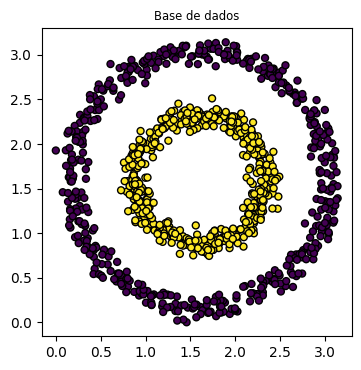

In [19]:
X, y = make_circles(
    (500, 500), factor=0.5, noise=0.05, random_state=seed
)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

### Execution

#### 70/30

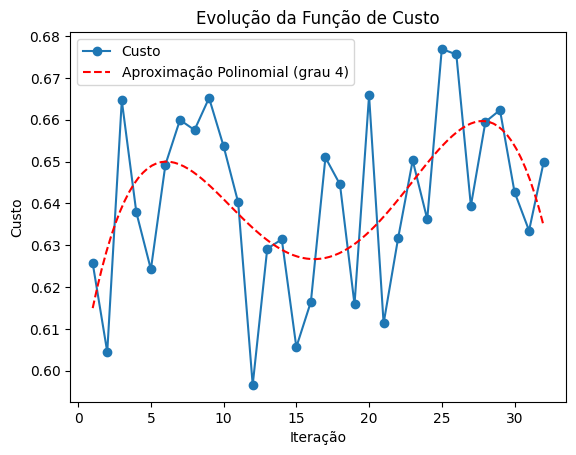

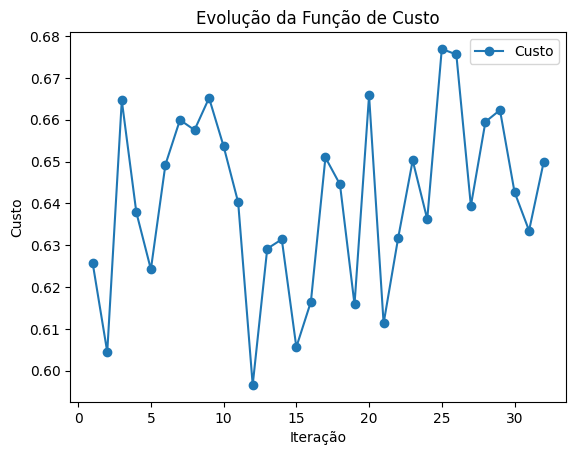

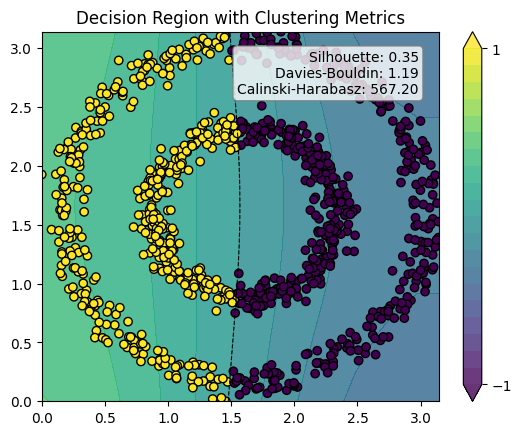

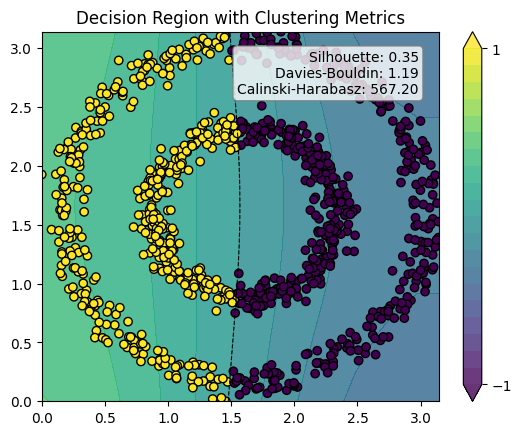

In [24]:
execute(X, "circle", iterations=100, batch_size=128, show_log=True)

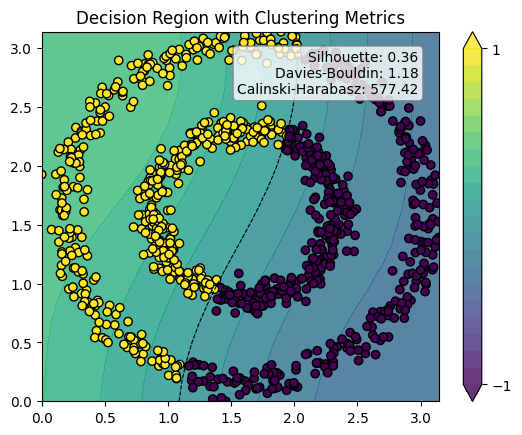

In [30]:
execute(X, "circle", iterations=100, batch_size=128, show_log=True)

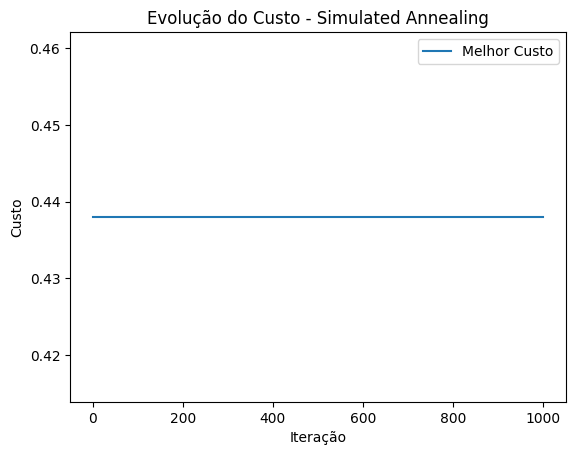

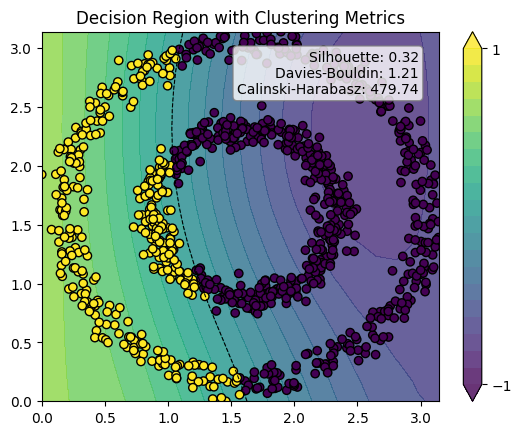

In [35]:
execute(X, "circle", iterations=1000, batch_size=128, show_log=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.9986
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.6487
Function value obtained: 0.4400
Current minimum: 0.4400
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.2373
Function value obtained: 1.0000
Current minimum: 0.4400
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.0942
Function value obtained: 0.4368
Current minimum: 0.4368
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.7233
Function value obtained: 0.5363
Current minimum: 0.4368
Iteration No: 6 started. Evaluating

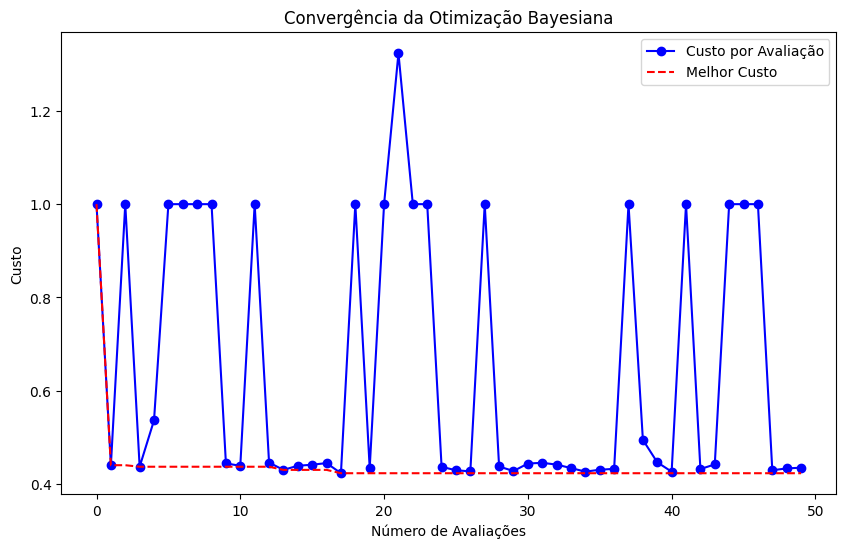

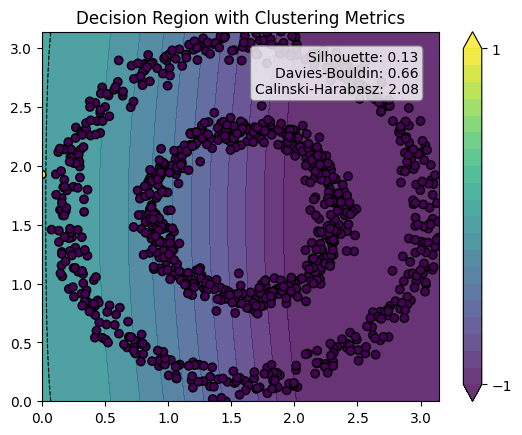

In [40]:
execute(X, "circle", iterations=1000, batch_size=128, show_log=True)

In [ ]:
execute(X, "circle", iterations=1000, batch_size=128, show_log=True)

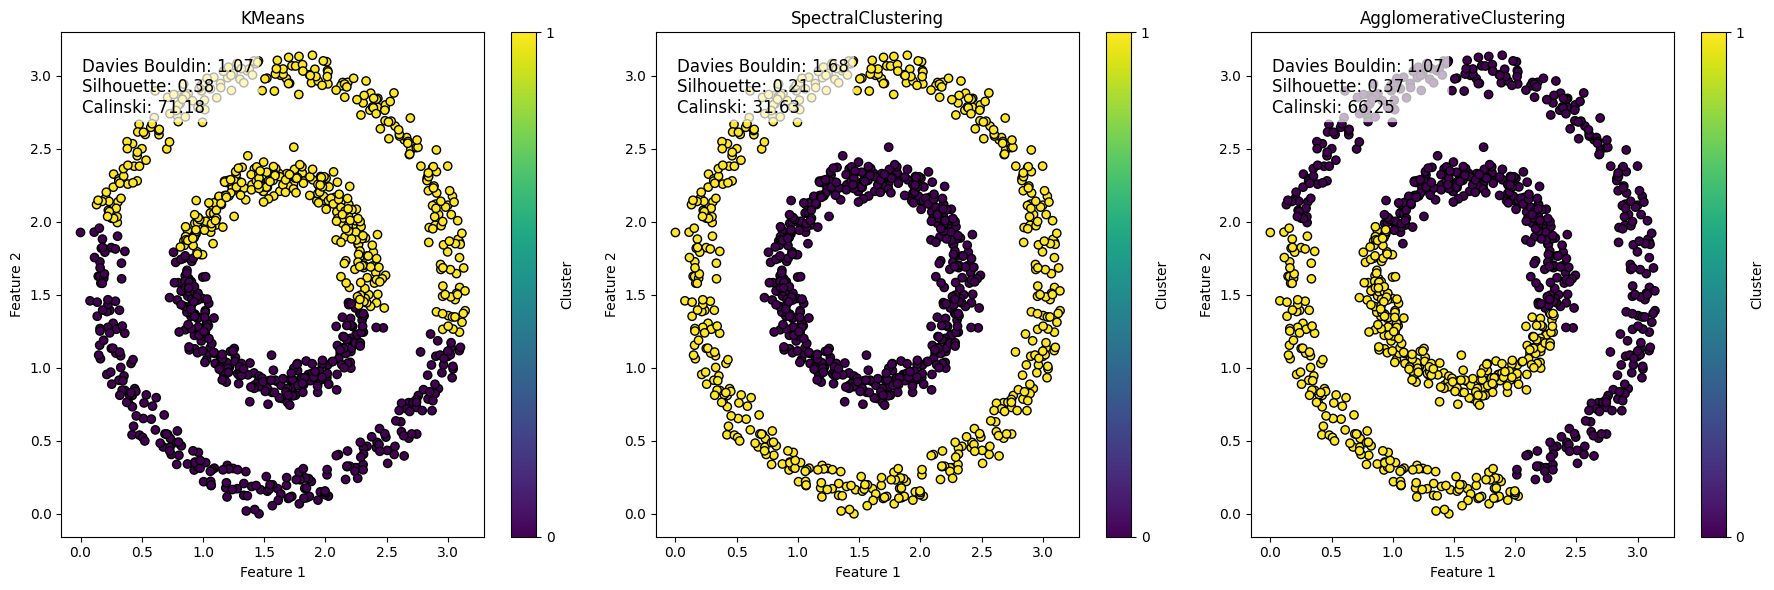

In [56]:
cluster_classical_kfold(X, n_clusters=2, k=10)

## 2 bubbles 2 class

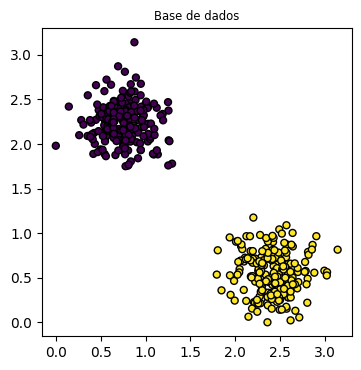

In [22]:
X, y = make_blobs(n_samples=400, centers=2, random_state=seed)

X, y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

### Execution

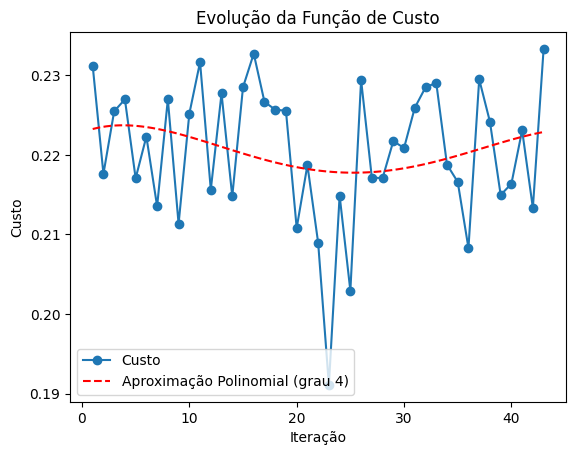

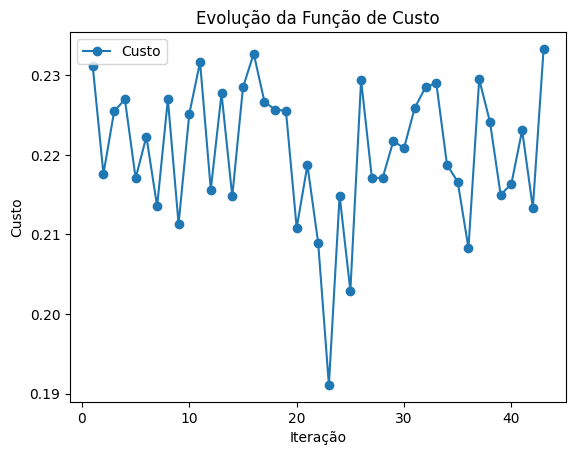

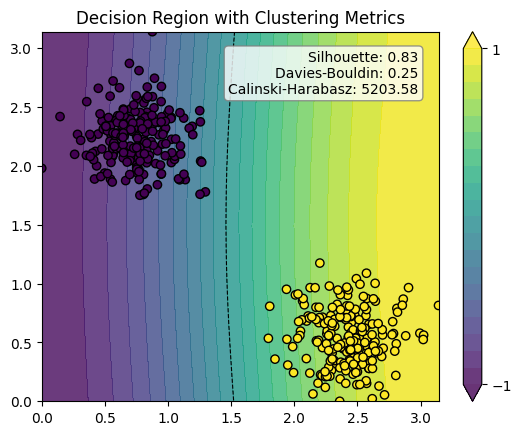

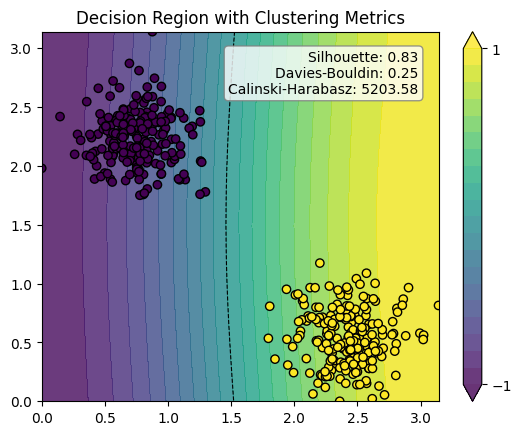

In [23]:
execute(X, "bubbles", iterations=100, batch_size=128, show_log=True)

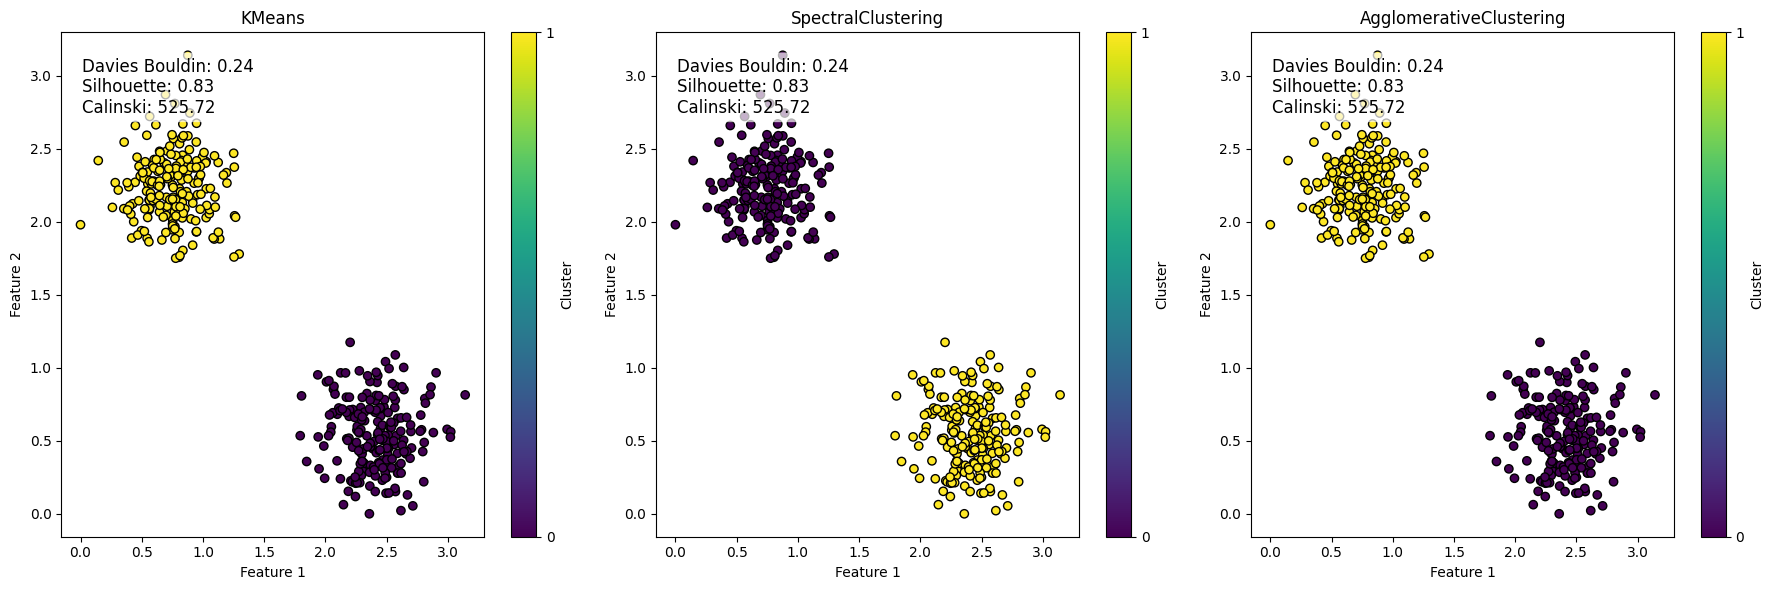

In [58]:
cluster_classical_kfold(X, n_clusters=2, k=10)